In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from preprocessing import preprocesamiento_basico, normalizar_datos
from graficos_modelos import graficar_auc_roc, graficar_matriz_confusion, graficar_curva_aprendizaje
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, mapear_target_binario, mapear_target_binario_a_categorico

# Redes neuronales

Definimos el método que generará la red neuronal con una arquitectura constante, la cual tendra dos capas ocultas de 10 y 8 neuronas respectivamente. A su vez, se utilizara la funcion de activación de tangente hiperbólica en las capas ocultas, y una sigmoidea en la capa de output ya que se trata de un problema de clasificación binaria. Por el mismo motivo, la funcion de perdida a optimizar será la cross-entropy.
El método de regularización a utilizar sera dropout con parametro 1/3 para mantener el modelo lo más simple posible y no sobrecargarlo con computo.

In [2]:
def crear_red(optimizer):
    red_neuronal = Sequential()
    red_neuronal.add(Dense(8, input_dim=18, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(5, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(1, activation='sigmoid'))
    red_neuronal.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=keras.metrics.AUC(name="auc"))
    return red_neuronal

## Modelo con preprocesamiento básico:

Obtención de datos y preprocesamiento

In [3]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()

In [4]:
dataframes_procesados = preprocesamiento_basico([X_train, X_test])
X_train = dataframes_procesados[0]
X_test = dataframes_procesados[1]

Los hiperparametros a definir en una red neuronal son:
- loss: Función de perdida a optimizar. En nuestro caso, por ser clasificación binaria, debe ser o softmax o binary cross-entropy. Elegimos la última por simpleza.
- optimizer: El optimizador que se utilizará para encontrar los mejores parametros (pesos y biases) de la red. 
    - learning_rate: Es un hiperparametro del optimizador que indica cuan grande sera el "aprendizaje" en cada epoca. Si es pequeño, tomara mas epocas el entrenamiento pero tendrá menos riesgo de diverger en los parametros como lo haría un learning rate alto
- metrics: Métricas que se utilizaran para mostrar y validar (en caso de usar callbacks) el resultado del entrenamiento
- epochs: Cantidad de iteraciones que realizara la red para ajustar sus pesos y biases

Los hiperparametros mencionados con anterioridad seran evaludados manualmente, tomando dos combinaciones posibles.
No se utilizara un algoritmo de busqueda de mejores parametros como grid search o random grid search debido a que la complejidad temporal de la red generaria tiempos de ejecución extremadamente largos.

Planteamos como posibles hiperpametros dos optimizadores, Adam que resulta un optimizador de complejidad media, y Adagrad que es un optimizador de complejidad mas elevada. 

Como el problema a resolver no es extremadamente complejo, no hay necesidad de complejizar tanto el computo de la red con optimizadores mas elaborados para obtener una buena performance.

Los learning rates propuestos se consideran relativamente valores bajos para que el aprendizaje sea suave y no abrupto/errático

In [5]:
mapeo_binario_v = np.vectorize(mapear_target_binario)

In [6]:
y_train_np = y_train['llovieron_hamburguesas_al_dia_siguiente'].to_numpy()
y_train_binario = mapeo_binario_v(y_train_np)

y_test_np = y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy()
y_test_binario = mapeo_binario_v(y_test_np)

Creamos entonces la red con el optimizador adam, el cual esta en el medio en la escala de complejidad y performance, y entrenamos un numero arbitrario de epochs halladas. Además agregamos criterio de early stopping para no sobreentrenar la red y que overfitee.

In [7]:
red_n = crear_red(keras.optimizers.Adam(learning_rate=0.0001))
red_n.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 152       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_auc', patience=50, mode='max')

In [9]:
historia = red_n.fit(
    X_train.values, y_train_binario, epochs=200, 
    validation_data=(X_test.values, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/200
3199/3199 [==============================] - 3s 727us/step - loss: 0.6651 - auc: 0.4992 - val_loss: 0.5411 - val_auc: 0.5000
Epoch 2/200
3199/3199 [==============================] - 2s 661us/step - loss: 0.5446 - auc: 0.5684 - val_loss: 0.4298 - val_auc: 0.8377
Epoch 3/200
3199/3199 [==============================] - 2s 665us/step - loss: 0.4437 - auc: 0.7778 - val_loss: 0.3945 - val_auc: 0.8484
Epoch 4/200
3199/3199 [==============================] - 2s 647us/step - loss: 0.4269 - auc: 0.7964 - val_loss: 0.4088 - val_auc: 0.8504
Epoch 5/200
3199/3199 [==============================] - 2s 663us/step - loss: 0.4218 - auc: 0.8031 - val_loss: 0.3844 - val_auc: 0.8572
Epoch 6/200
3199/3199 [==============================] - 2s 652us/step - loss: 0.4190 - auc: 0.8068 - val_loss: 0.3838 - val_auc: 0.8573
Epoch 7/200
3199/3199 [==============================] - 2s 671us/step - loss: 0.4174 - auc: 0.8096 - val_loss: 0.3796 - val_auc: 0.8586
Epoch 8/200
3199/3199 [==================

### Curva de aprendizaje


Graficamos la curva de aprendizaje para tener una mejor idea de como fue el entrenamiento de nuestra red

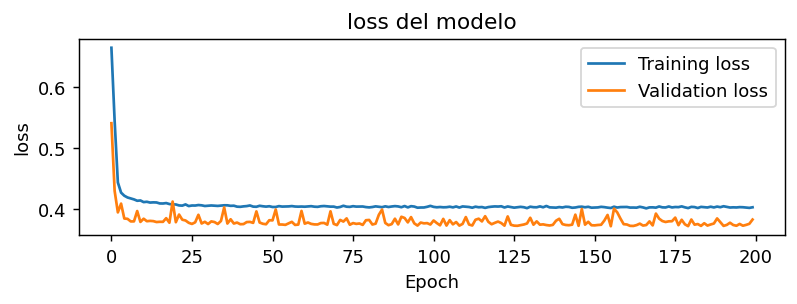

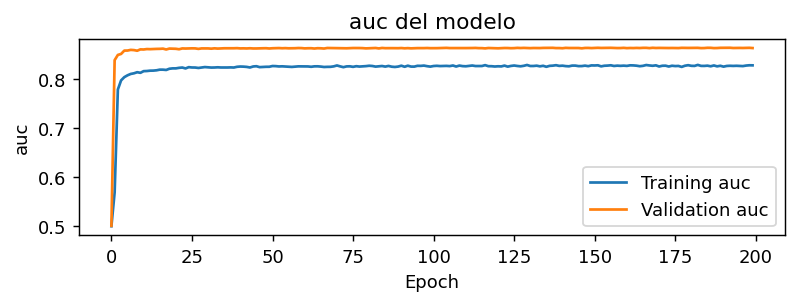

In [10]:
graficar_curva_aprendizaje(historia,'loss')
graficar_curva_aprendizaje(historia,'auc')

### Predicción del modelo sobre holdout

Una vez que vimos que no se produjo un overfitting (dado que las curvas de validation y training son muy similares) y que la métrica alcanzada es lo suficientemente buena, realizamos la predicción sobre los valores de holdout, y gráficamos la curva AUC-ROC y la matriz de confusión

In [11]:
y_pred = red_n.predict(X_test)

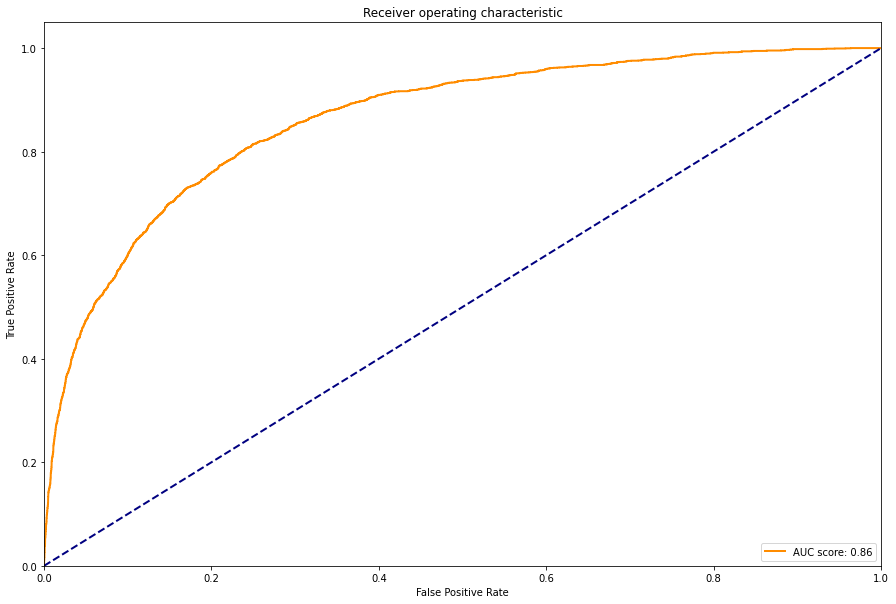

AUC-ROC para este modelo es: 0.8624515405972958


In [12]:
graficar_auc_roc(y_test_binario, y_pred) 

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


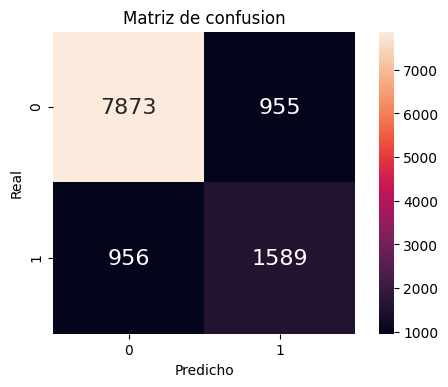

In [13]:
graficar_matriz_confusion(y_test_binario, y_pred.round())

In [14]:
print(classification_report(y_test_binario, y_pred.round(), target_names=['no', 'si']))

              precision    recall  f1-score   support

          no       0.89      0.89      0.89      8828
          si       0.62      0.62      0.62      2545

    accuracy                           0.83     11373
   macro avg       0.76      0.76      0.76     11373
weighted avg       0.83      0.83      0.83     11373



Aunque a partir de la red obtuvimos una métrica bastante buena, intentaremos mejorarla con un optimizador mas sofisticado que adam, como lo es adagrad, y ampliando la cantidad de epochs a 500.

In [15]:
red_sofisticada = crear_red(keras.optimizers.Adagrad(learning_rate=0.0001))
red_sofisticada.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 152       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 45        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [16]:
historia_sofisticada = red_sofisticada.fit(
    X_train.values, y_train_binario, epochs=500, 
    validation_data=(X_test.values, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/500
3199/3199 [==============================] - 3s 731us/step - loss: 0.7611 - auc: 0.4637 - val_loss: 0.6105 - val_auc: 0.4353
Epoch 2/500
3199/3199 [==============================] - 2s 656us/step - loss: 0.7042 - auc: 0.4854 - val_loss: 0.5877 - val_auc: 0.4615
Epoch 3/500
3199/3199 [==============================] - 2s 658us/step - loss: 0.6918 - auc: 0.4843 - val_loss: 0.5768 - val_auc: 0.4706
Epoch 4/500
3199/3199 [==============================] - 2s 654us/step - loss: 0.6787 - auc: 0.4922 - val_loss: 0.5704 - val_auc: 0.4798
Epoch 5/500
3199/3199 [==============================] - 2s 686us/step - loss: 0.6761 - auc: 0.4895 - val_loss: 0.5661 - val_auc: 0.4846
Epoch 6/500
3199/3199 [==============================] - 2s 641us/step - loss: 0.6687 - auc: 0.4958 - val_loss: 0.5631 - val_auc: 0.4867
Epoch 7/500
3199/3199 [==============================] - 2s 678us/step - loss: 0.6660 - auc: 0.4936 - val_loss: 0.5606 - val_auc: 0.4886
Epoch 8/500
3199/3199 [==================

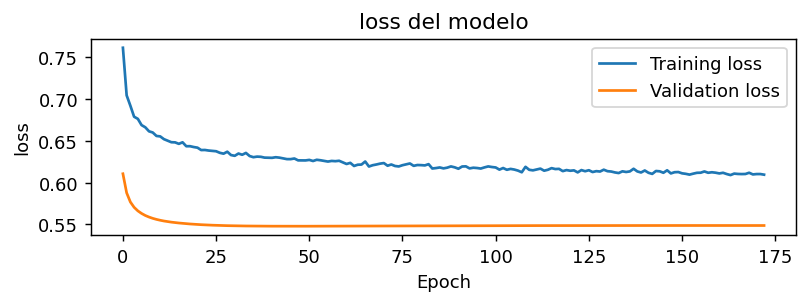

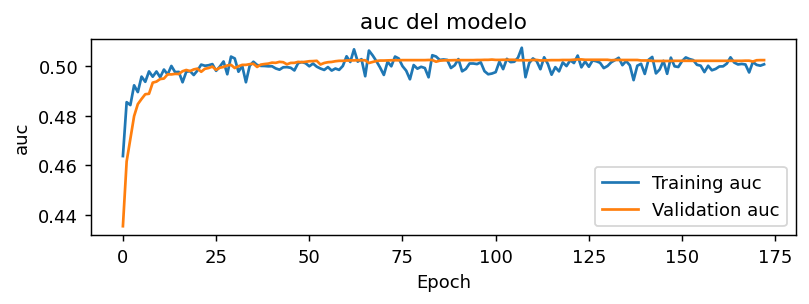

In [17]:
graficar_curva_aprendizaje(historia_sofisticada,'loss')
graficar_curva_aprendizaje(historia_sofisticada,'auc')

In [18]:
y_pred_sofisticado = red_sofisticada.predict(X_test)

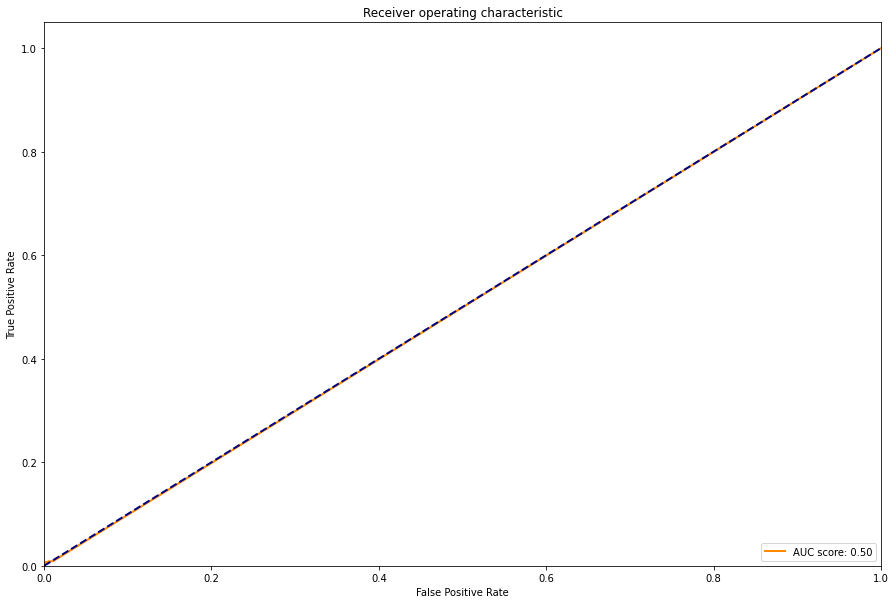

AUC-ROC para este modelo es: 0.49911533493625837


In [19]:
graficar_auc_roc(y_test_binario, y_pred_sofisticado) 

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


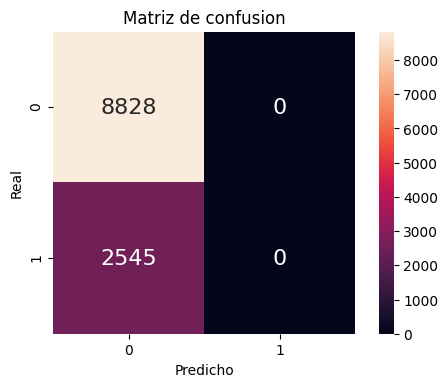

In [20]:
graficar_matriz_confusion(y_test_binario, y_pred_sofisticado.round())

In [21]:
print(classification_report(y_test_binario, y_pred_sofisticado.round(), target_names=['no', 'si']))

              precision    recall  f1-score   support

          no       0.78      1.00      0.87      8828
          si       0.00      0.00      0.00      2545

    accuracy                           0.78     11373
   macro avg       0.39      0.50      0.44     11373
weighted avg       0.60      0.78      0.68     11373



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vemos que nuestro intento de mejorar la performance resulto completamente contraproducente, habiendo generado un modelo el cual tiene una metrica AUC ROC muy baja. Esto puede deberse a que si bien el optimizador adagrad es mas complejo y en general mas sofisticado, no funciona tan bien para la arquitectura y el set de datos y la prediccion de lluvia de hamburguesas.

Además se observa que el modelo no logra mejorar la métrica auc para el set de validación y para training es muy errática, a pesar de tener un learning rate bastante bajo. 

Como las métricas de loss tanto para el set de validación como para el de entramiento dan una curva bastante similar pero trasladada hacia arriba, no podemos afirmar que el problema se deba a overfit.

Por esto, no será tenido en cuenta en la conclusión

# Modelo con preprocesamiento normalizados

Intentaremos mejorar la performance agregando el preprocesamiento de normalizacion de los datos ya que en general suele ayudar a los modelos.

In [22]:
dataframes_normalizados = normalizar_datos([X_train, X_test])
X_train_norm = dataframes_normalizados[0]
X_test_norm = dataframes_normalizados[1]

In [23]:
red_norm = crear_red(keras.optimizers.Adam(learning_rate=0.0001))

historia_norm = red_norm.fit(
    X_train_norm, y_train_binario, epochs=200, 
    validation_data=(X_test_norm, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/200
3199/3199 [==============================] - 3s 708us/step - loss: 0.5369 - auc: 0.7705 - val_loss: 0.4198 - val_auc: 0.8499
Epoch 2/200
3199/3199 [==============================] - 2s 660us/step - loss: 0.4190 - auc: 0.8225 - val_loss: 0.3830 - val_auc: 0.8605
Epoch 3/200
3199/3199 [==============================] - 2s 713us/step - loss: 0.4032 - auc: 0.8327 - val_loss: 0.3769 - val_auc: 0.8634
Epoch 4/200
3199/3199 [==============================] - 2s 742us/step - loss: 0.3964 - auc: 0.8383 - val_loss: 0.3736 - val_auc: 0.8647
Epoch 5/200
3199/3199 [==============================] - 2s 700us/step - loss: 0.3934 - auc: 0.8403 - val_loss: 0.3716 - val_auc: 0.8658
Epoch 6/200
3199/3199 [==============================] - 2s 682us/step - loss: 0.3901 - auc: 0.8430 - val_loss: 0.3700 - val_auc: 0.8666
Epoch 7/200
3199/3199 [==============================] - 2s 687us/step - loss: 0.3865 - auc: 0.8464 - val_loss: 0.3689 - val_auc: 0.8668
Epoch 8/200
3199/3199 [==================

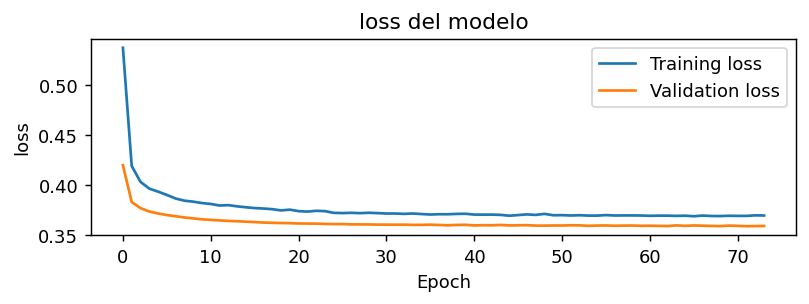

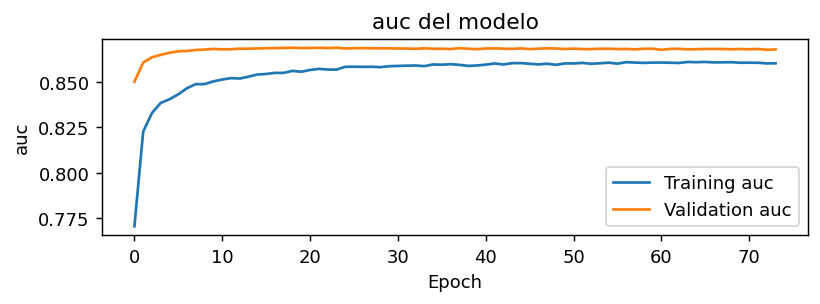

In [24]:
graficar_curva_aprendizaje(historia_norm,'loss')
graficar_curva_aprendizaje(historia_norm,'auc')

In [25]:
y_pred_norm = red_norm.predict(X_test_norm)

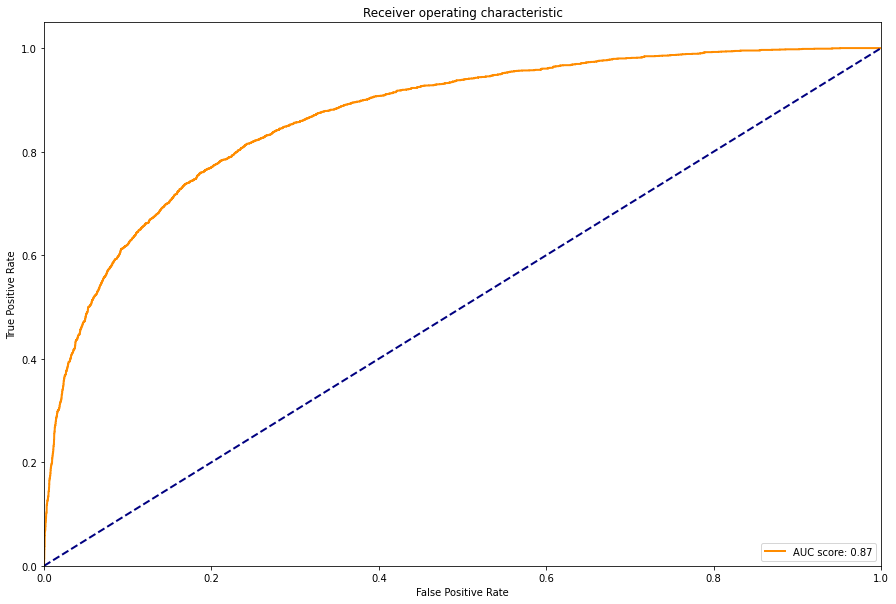

AUC-ROC para este modelo es: 0.8677327809443608


In [26]:
graficar_auc_roc(y_test_binario, y_pred_norm) 

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


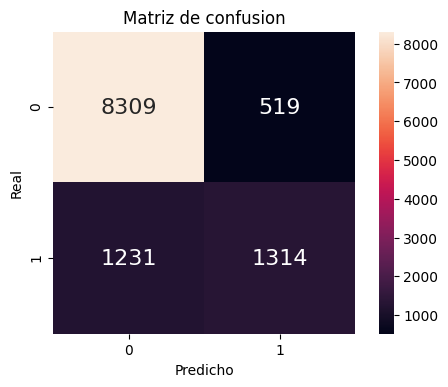

In [27]:
graficar_matriz_confusion(y_test_binario, y_pred_norm.round()) 

In [28]:
print(classification_report(y_test_binario, y_pred_norm.round(), target_names=['no', 'si']))

              precision    recall  f1-score   support

          no       0.87      0.94      0.90      8828
          si       0.72      0.52      0.60      2545

    accuracy                           0.85     11373
   macro avg       0.79      0.73      0.75     11373
weighted avg       0.84      0.85      0.84     11373



# Conclusiones y predicción final

Vemos que el modelo que mejor funciona según la metrica AUC de keras es el que utiliza a adam como optimizador y 200 epochs. Sin embargo el criterio de early stopping con una paciencia relativamente baja (50) nos indica que aproximadamente a partir de la epoch 20 (dado que el entrenamiento se frena en la epoca 70) ya no tiene sentido seguir entrenando. Por lo tanto la complejidad computacional que puede generar la normalizacion de los datos, podría verse compensada por lo que se ahorra al entrenar la red. 

Sin embargo vemos en la matriz de confusión que este modelo pierde instancias de True positives acertadas, y mejora los true negatives absolutos. Esto podría verse como una desventaja frente al primer modelo ya que a grandes rasgos, lo dificil del problema propuesto por Flint es predecir los true positives. 

A pesar de que el primer modelo resulte en mayores true positives acertados, también aumenta la proporción de false positives, resultando en una métrica de precision menor, y en una métrica de recall mas alta.

Concluimos entonces que por tener metricas auc-roc, accuracy y precision mas altas, el mejor modelo para predecir será el ultimo, que utiliza el preprocesamiento normalizado. 

Procedemos a realizar la prediccion del dataset nuevo con este modelo y guardarlo en el archivo csv

In [32]:
def formatear_prediccion_red(predicciones):
    pred_finales = []
    for pred in predicciones:
        pred_finales.append(pred[0])
    return pred_finales 

In [33]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final = preprocesamiento_basico([df_prediccion_final])[0]
df_prediccion_final = normalizar_datos([df_prediccion_final])

predicciones = red_norm.predict(df_prediccion_final).round()
mapeo_categorico_v = np.vectorize(mapear_target_binario_a_categorico)
predicciones = mapeo_categorico_v(predicciones)
predicciones = formatear_prediccion_red(predicciones)

exportar_prediccion_final(ids, predicciones, 'red_neuronal')